In [1]:
import qutip as qt
import numpy as np

# Tracking info of simulations 
import tqdm
import time
import warnings

#Saving data
import pandas as pd
import json
import os

import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.gridspec import GridSpec

In [2]:
import sys
sys.path.append('/Users/omichel/Desktop/qilimanjaro/projects/quantum_transport/quantum_state_transfer/src')

import model_building as md
import Hamiltonian as Ham
import dynamics as dyn
import data_handling as dh
import plots as plots


## Useful functions

In [3]:
def initialize_system(state_dictionary, N):
    initial_state = md.create_domain_wall_state(state_dictionary, register='Alice')
    final_state   = md.create_domain_wall_state(state_dictionary, register='Bob')

    initial_chain = md.initialize_general_system(N, initial_state, register='Alice')
    final_chain   = md.initialize_general_system(N, final_state, register='Bob')

    register_size = len(initial_state.dims[0])
    
    return initial_chain, final_chain, register_size

def build_hamiltonians(N, lmd, J, reg_size):

    H_transport = Ham.Hamiltonian(system_size = N,
                        mode = "forward",
                        lambda_factor = lmd,
                        global_J = J
                        )
    H_reset     = Ham.Hamiltonian(system_size = N,
                        mode = "backward",
                        lambda_factor = lmd,
                        register_size = reg_size,
                        global_J = J
                        )
    
    return H_transport, H_reset


def calculate_logs(x_data, y_data):
    log_axis = [np.log(i) for i in x_data]
    log_error = [np.log(1-i) for i in y_data]
    return log_axis, log_error

def calculate_logs_2(x_data, y_data):
    log_axis = [np.log(i) for i in x_data]
    log_error = [np.log(i) for i in y_data]
    return log_axis, log_error

# PROTOCOL TEST

In [3]:
#Parameters

N=10
lmd = 0.02272
J = 0.5
state_dictionary = {"001":1}
state_dictionary = {"1":1}


ti = 0
tf = 150

Nsteps = 500

In [4]:

initial_state = md.crate_domain_wall_state(state_dictionary, register='Alice')
final_state   = md.crate_domain_wall_state(state_dictionary, register='Bob')

initial_chain = md.initialize_general_system(N, initial_state, register='Alice')
final_chain   = md.initialize_general_system(N, final_state, register='Bob')

In [5]:
#Create Hamiltonians
register_size = len(initial_state.dims[0])


H_transport = Ham.Hamiltonian(system_size = N,
                     mode = "forward",
                     lambda_factor = lmd,
                     global_J = J
                     )
H_reset     = Ham.Hamiltonian(system_size = N,
                     mode = "backward",
                     lambda_factor = lmd,
                     register_size = register_size,
                     global_J = J
                     )

In [6]:
#Algorithm

total_full_fidelity, magnetizations = dyn.TwoStepAlgorithm(initial_chain, final_chain, H_transport, H_reset, ti, tf, Nsteps, AutoSwitch=True)

/Users/omichel/Desktop/qilimanjaro/projects/quantum_transport/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 514/514 [00:00<00:00, 4776.42it/s]


In [7]:
f_filename = dh.create_data_filename(N, J, lmd, state_dictionary, base_name='fidelity')
z_filename = dh.create_data_filename(N, J, lmd, state_dictionary, base_name='z_expectation')

f_data_directory = 'data_files/fidelity/'
z_data_directory = 'data_files/z_expectation/'

f_plot_directory = 'figures/fidelity/'
z_plot_directory = 'figures/z_expectation/' 


In [8]:
dh.save_numpy_array(total_full_fidelity, f'{f_data_directory}{f_filename}')
dh.save_numpy_array(magnetizations, f'{z_data_directory}{z_filename}')

In [ ]:
plots.plot_test_fidelity(total_full_fidelity, N, f'{f_plot_directory}{f_filename}')

In [ ]:
plots.plot_test_z_expectations(magnetizations, N, f'{z_plot_directory}{z_filename}')

# J VS LAMBDA TEST

In [ ]:
#Constant simulation parameters
N = 12
lmd = 0.02272
ti = 0
tf = 150
step_number = 5000

ratios = range(1,41) # will be used to calculate J accordingly
# ratios = np.linspace(30,32,20)


# Generate initial and target statess
# state_dictionary = {"1":1}
# state_dictionary = {"1":1, "0":1}
# state_dictionary = {"11":1, "00":1}
state_dictionary = {"111":1, "000":1}

initial_system, final_system, register_size = initialize_system(state_dictionary, N)
maximum_fidelities = []

for ratio in ratios:
    J = ratio*lmd
    H_transport, H_reset = build_hamiltonians(N, lmd, J, register_size)
    total_full_fidelity, magnetizations = dyn.TwoStepAlgorithm(initial_system, final_system, H_transport, H_reset, ti, tf, step_number, AutoSwitch=True)
    maximum_fidelities.append(max(total_full_fidelity))
    print(ratio, " : ", max(int(np.argmin(magnetizations[:step_number,-3])),10))

1  :  888
2  :  1233
3  :  4998
4  :  4634
5  :  4716
6  :  4755
7  :  4763
8  :  4478
9  :  4506
10  :  4525
11  :  4540
12  :  4551
13  :  4559
14  :  4566
15  :  4571
16  :  4576
17  :  4579
18  :  4582
19  :  4585
20  :  4587
21  :  4589
22  :  4591
23  :  4592
24  :  4594
25  :  4595
26  :  4596
27  :  4597
28  :  4597
29  :  4598
30  :  4599
31  :  4599
32  :  4600
33  :  4600
34  :  4601
35  :  4601
36  :  4602
37  :  4602
38  :  4602
39  :  4603
40  :  4603


In [11]:
ratio_filename = dh.create_data_filename(N, f'{ratios[-1]}', lmd, state_dictionary, base_name='ratio')
print(ratio_filename)
dh.save_plot_data_to_csv(ratios, maximum_fidelities, f'../data_files/ratios/{ratio_filename}')

ratio_N12_J40_L0.023_1_1_20250925_114757
Data saved to ../data_files/ratios/ratio_N12_J40_L0.023_1_1_20250925_114757
First 5 rows:
Time_step	Fidelity
1.0000	0.0997
2.0000	0.1933
3.0000	0.5360
4.0000	0.6980
5.0000	0.8317


In [12]:
ratios_1, values_1, recovered_filename = dh.read_plot_data_from_csv(f"../data_files/ratios/{ratio_filename}.csv")

log_ratios_1, log_errors_1 = calculate_logs(ratios_1, values_1)

<Figure size 2400x1800 with 0 Axes>

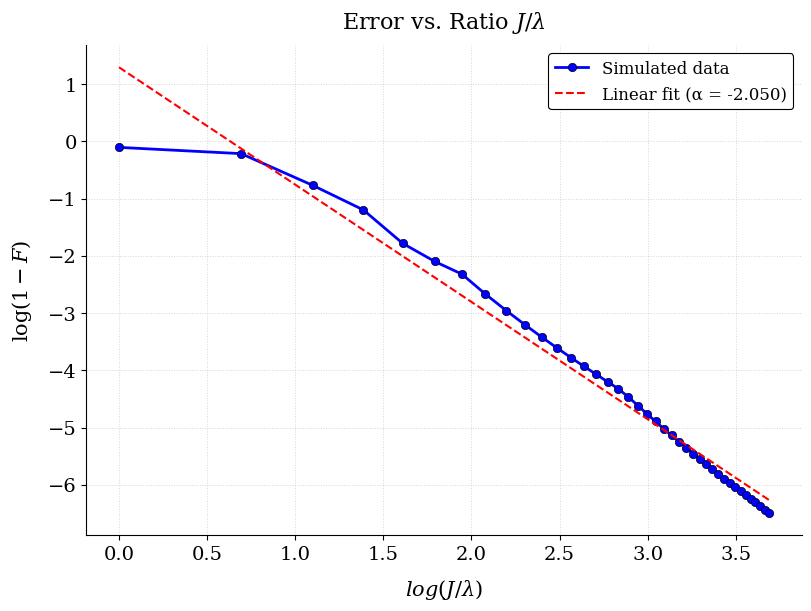

In [13]:
plots.plot_ratios_trend_slope(x_data=log_ratios_1[:], y_data=log_errors_1[:],log_scale=False, filepath=f'../figures/ratios/{recovered_filename}')

In [20]:
print((log_errors_1[-1]-log_errors_1[0])/(log_ratios_1[-1]-log_ratios_1[0]))

-1.056974837964226


# J VS LAMBDA MAIN CALCULATION

In [ ]:
#Constant simulation parameters
N = 13
lmd = 0.02272
ti = 0
tf = 150
step_number = 6000

ratios = range(1,41) # will be used to calculate J accordingly


# Generate initial and target statess
# state_dictionary = {"1":1}
# state_dictionary = {"1":1, "0":1}
# state_dictionary = {"11":1, "00":1}
# state_dictionary = {"111":1, "000":1}

# state_dictionaries = [{"1":1}, {"1":1, "0":1}, {"11":1, "00":1}]
state_dictionaries = [{"111":1, "000":1}]
filenames = []
for dictionary in state_dictionaries:

    initial_system, final_system, register_size = initialize_system(dictionary, N)
    maximum_fidelities = []

    for ratio in ratios:
        print(ratio)
        J = ratio*lmd
        H_transport, H_reset = build_hamiltonians(N, lmd, J, register_size)
        total_full_fidelity, magnetizations = dyn.TwoStepAlgorithm(initial_system, final_system, H_transport, H_reset, 
                                                                   ti, tf, step_number, AutoSwitch=True)
        maximum_fidelities.append(max(total_full_fidelity))
        print(1-max(total_full_fidelity))

    ratio_filename = dh.create_data_filename(N, f'{ratios[-1]}', lmd, dictionary, 'ratio')
    dh.save_plot_data_to_csv(ratios, maximum_fidelities, f'../data_files/ratios/{ratio_filename}')
    filenames.append(ratio_filename)

In [ ]:
ratios_1,    values_1,    recovered_filename_1 = dh.read_plot_data_from_csv   (f"../data_files/ratios/{filenames[0]}.csv")
ratios_plus, values_plus, recovered_filename_plus = dh.read_plot_data_from_csv(f"../data_files/ratios/{filenames[1]}.csv")
ratios_bell, values_bell, recovered_filename_bell = dh.read_plot_data_from_csv(f"../data_files/ratios/{filenames[2]}.csv")
ratios_ghz,  values_ghz,  recovered_filename_ghz = dh.read_plot_data_from_csv (f"../data_files/ratios/{filenames[3]}.csv")

log_ratios_1,    log_errors_1    =  calculate_logs(ratios_1, values_1)
log_ratios_plus, log_errors_plus =  calculate_logs(ratios_plus, values_plus)
log_ratios_bell, log_errors_bell =  calculate_logs(ratios_bell, values_bell)
log_ratios_ghz,  log_errors_ghz  =  calculate_logs(ratios_ghz, values_ghz)

In [45]:
ratios_1,    values_1,    recovered_filename_1    = dh.read_plot_data_from_csv("/Users/omichel/Desktop/qilimanjaro/projects/quantum_transport/quantum_state_transfer/data_files/paper/ratios/ratio_N13_J40_L0.023_1_1_20250922_133358.csv")
ratios_plus, values_plus, recovered_filename_plus = dh.read_plot_data_from_csv("/Users/omichel/Desktop/qilimanjaro/projects/quantum_transport/quantum_state_transfer/data_files/paper/ratios/ratio_N13_J40_L0.023_1_1_0_1_20250922_134045.csv")
ratios_bell, values_bell, recovered_filename_bell = dh.read_plot_data_from_csv("/Users/omichel/Desktop/qilimanjaro/projects/quantum_transport/quantum_state_transfer/data_files/paper/ratios/ratio_N13_J40_L0.023_11_1_00_1_20250922_134717.csv")
ratios_ghz,  values_ghz,  recovered_filename_ghz  = dh.read_plot_data_from_csv("/Users/omichel/Desktop/qilimanjaro/projects/quantum_transport/quantum_state_transfer/data_files/paper/ratios/ratio_N13_J40_L0.023_111_1_000_1_20250922_135719.csv")

log_ratios_1,    log_errors_1    =  calculate_logs(ratios_1, values_1)
log_ratios_plus, log_errors_plus =  calculate_logs(ratios_plus, values_plus)
log_ratios_bell, log_errors_bell =  calculate_logs(ratios_bell, values_bell)
log_ratios_ghz,  log_errors_ghz  =  calculate_logs(ratios_ghz, values_ghz)

In [46]:
ratios_bell_1, values_bell_1, recovered_filename_bell_1 = dh.read_plot_data_from_csv("/Users/omichel/Desktop/qilimanjaro/projects/quantum_transport/quantum_state_transfer/data_files/paper/ratios/ratio_N13_J40_L0.023_11_1_00_1_20250922_134717.csv")
ratios_bell_2, values_bell_2, recovered_filename_bell_2 = dh.read_plot_data_from_csv("/Users/omichel/Desktop/qilimanjaro/projects/quantum_transport/quantum_state_transfer/data_files/ratios/ratio_N13_J31_L0.023_11_1_00_1_20250925_105940_None.csv")

ratios_bell = ratios_bell_1[:26] + ratios_bell_2
values_bell = values_bell_1[:26] + values_bell_2

log_ratios_bell, log_errors_bell =  calculate_logs(ratios_bell, values_bell)


In [24]:
print(ratios_bell_2)

[26.0, 27.0, 28.0, 29.0, 30.0, 31.0]


In [15]:
print(log_errors_ghz)

[np.float64(-0.6931471805599451), np.float64(-0.6931471805599451), np.float64(-0.6931471805599451), np.float64(-0.6931471805599451), np.float64(-0.6931471805599451), np.float64(-0.6931471805599451), np.float64(-0.6931471805599451), np.float64(-0.6931471805599451), np.float64(-0.6931471805599451), np.float64(-2.642671818373903), np.float64(-2.856212425895366), np.float64(-2.824288111433558), np.float64(-2.9939541575220168), np.float64(-3.1580577865002883), np.float64(-3.307629120935724), np.float64(-3.4359963852643456), np.float64(-3.567148262935648), np.float64(-3.715464513792091), np.float64(-3.828453409794353), np.float64(-3.945053390769121), np.float64(-4.0453529314641266), np.float64(-4.165231540311002), np.float64(-4.240210866994088), np.float64(-4.334777930664831), np.float64(-4.4357957932196985), np.float64(-4.505181263613679), np.float64(-4.5976894958898535), np.float64(-4.654619250561479), np.float64(-4.738467200460902), np.float64(-4.814672328792254), np.float64(-4.8825737434

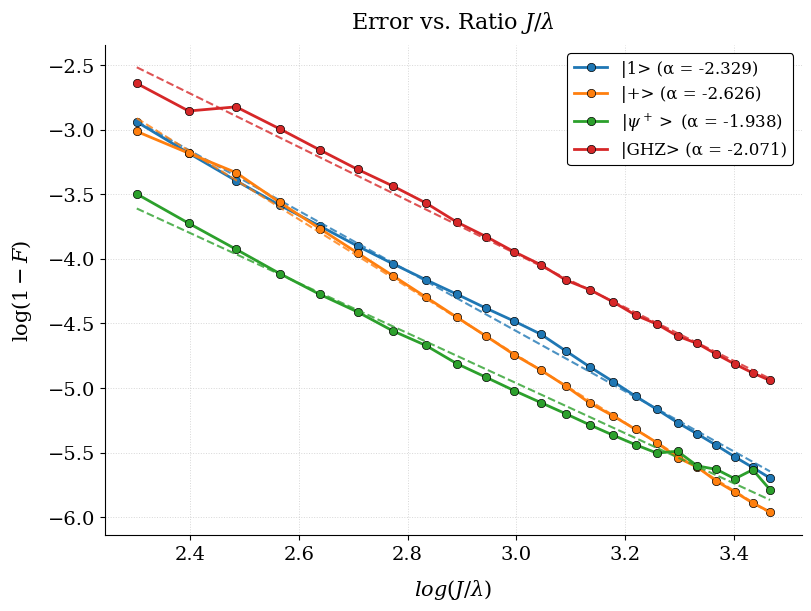

In [47]:
min_index =9
max_index = 32
error_dictionary = {'|1>':log_errors_1[min_index:max_index], '|+>':log_errors_plus[min_index:max_index], '$|\psi^+>$':log_errors_bell[min_index:max_index], '|GHZ>':log_errors_ghz[min_index:max_index]}
plots.plot_multiple_ratio_trend_slope_2(x_data = log_ratios_1[min_index:max_index], y_data_dict=error_dictionary, log_scale=False, show_trend=True, filepath='../figures/paper/ratio_all_curves_test_2')

<Figure size 2400x1800 with 0 Axes>

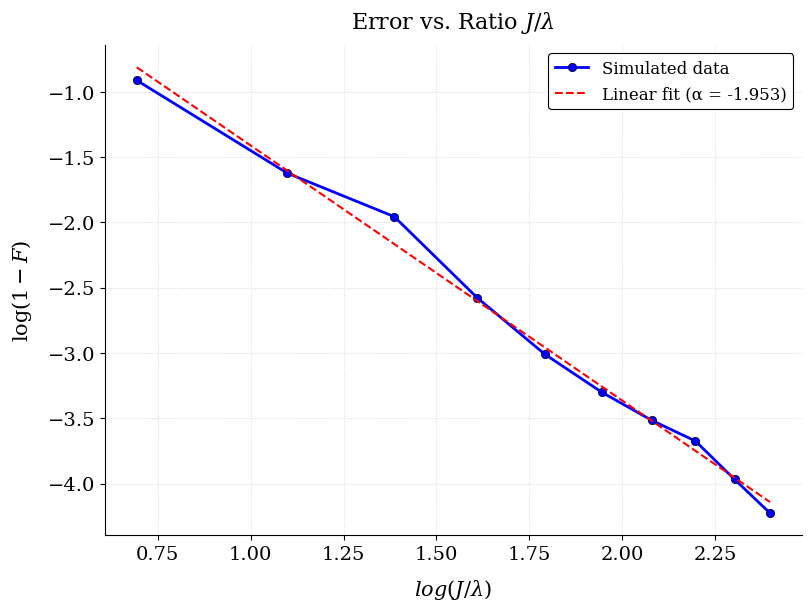

In [28]:
plots.plot_ratios_trend_slope(x_data=log_ratios_1[1:11], y_data=log_errors_1[1:11],log_scale=False, filepath=f'figures/ratios/{recovered_filename_1}')

<Figure size 2400x1800 with 0 Axes>

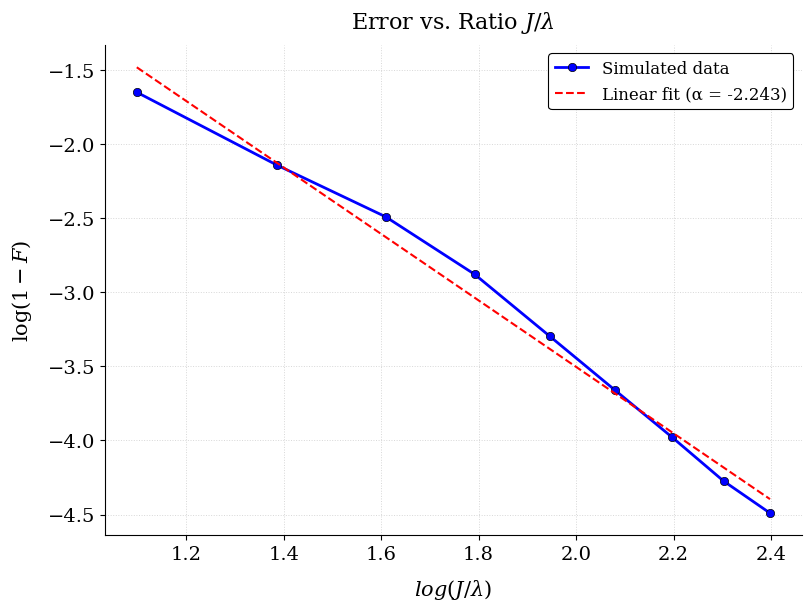

In [29]:
plots.plot_ratios_trend_slope(x_data=log_ratios_plus[2:11], y_data=log_errors_plus[2:11],log_scale=False, filepath=f'figures/ratios/{recovered_filename_plus}')

<Figure size 2400x1800 with 0 Axes>

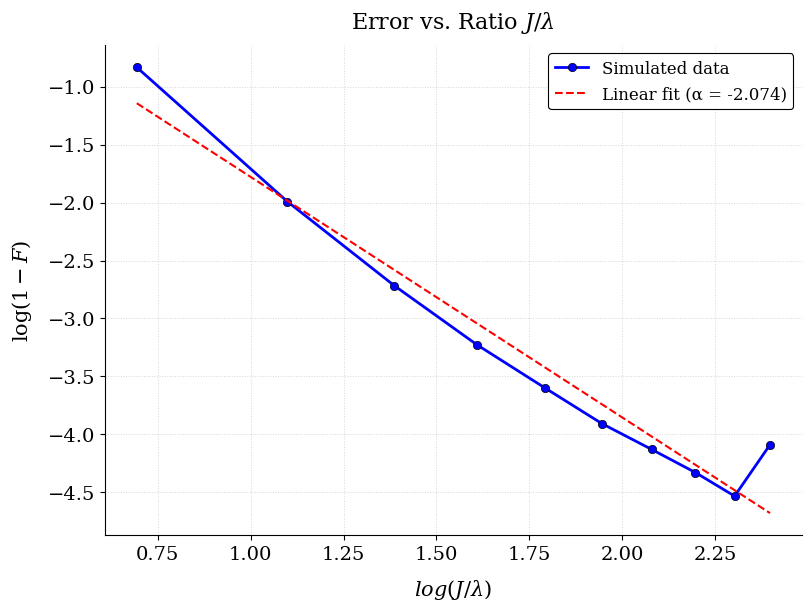

In [30]:
plots.plot_ratios_trend_slope(x_data=log_ratios_bell[1:11], y_data=log_errors_bell[1:11],log_scale=False, filepath=f'figures/ratios/{recovered_filename_bell}')

<Figure size 2400x1800 with 0 Axes>

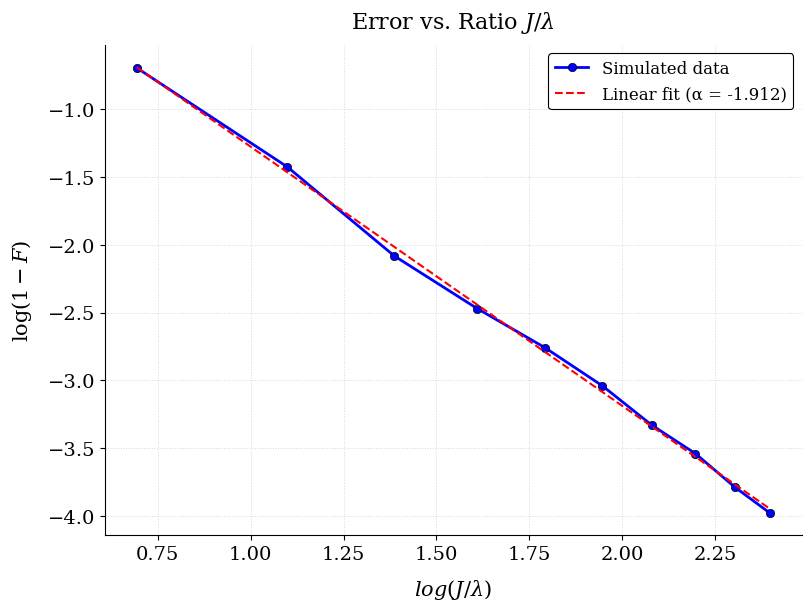

In [31]:
plots.plot_ratios_trend_slope(x_data=log_ratios_ghz[1:11], y_data=log_errors_ghz[1:11],log_scale=False, filepath=f'figures/ratios/{recovered_filename_ghz}')